# **Import Necessary Libraries**

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 60.3 MB/s eta 0:00:00


In [3]:
# For downloading the dataset from Google Drive
import gdown

# For unzipping the downloaded dataset
import zipfile

# For handling file and directory operations
import os

# For inline plotting in Jupyter notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and Keras modules for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# FAISS for fast similarity search
import faiss


# **Download and Extract Dataset from Google Drive**

In [4]:
# Extracted file ID from the Google Drive link
file_id = '1E8lqZfPXj70j6G5CkSJzlqr-OxZXKFIB'

# Correct Google Drive URL for gdown
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file from Google Drive
output = 'image1.zip'
gdown.download(url, output, quiet=False)

# Path to the downloaded file
zip_file_path = os.path.join('/content', output)

# Path to extract the files into a folder named 'dataset'
extract_path = os.path.join('/content', 'dataset')

# Ensure the 'dataset' folder exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file if it is valid
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("The downloaded file is not a valid zip file.")


Downloading...
From (original): https://drive.google.com/uc?id=1E8lqZfPXj70j6G5CkSJzlqr-OxZXKFIB
From (redirected): https://drive.google.com/uc?id=1E8lqZfPXj70j6G5CkSJzlqr-OxZXKFIB&confirm=t&uuid=8131330d-67d4-48b1-a7ff-2a3c4a60f7f5
To: /content/image1.zip
100%|██████████| 785M/785M [00:10<00:00, 77.1MB/s]


Extraction complete.


# **Load and Modify InceptionV3 Model**

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3

# Load and modify InceptionV3 model
def create_inceptionv3_model(input_shape=(224, 224, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the last 45 layers of InceptionV3
    for layer in base_model.layers[-40:]:
        layer.trainable = True

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Instantiate the model
model = create_inceptionv3_model()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# **Create Image Generator for Loading Images in Batches**

In [6]:
# Function to create a generator for loading images in batches
def image_generator(dataset_dir, img_size=(224, 224), batch_size=64):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,  # No labels are required if just generating images
        shuffle=False  # Shuffle should be False to maintain order of file paths
    )

    return generator

# Path to your dataset
dataset_dir = '/content/dataset'

# Create a generator
batch_size = 64
img_size = (224, 224)
image_gen = image_generator(dataset_dir, img_size, batch_size)

# Store paths for reference
image_paths = image_gen.filepaths


Found 84986 images belonging to 106 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:146: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


# **Generate Feature Embeddings for All Images**

In [7]:
import numpy as np
# Generate feature embeddings for all images
def get_feature_embeddings(generator):
    return model.predict(generator, verbose=1)

# Assuming model is defined and loaded before this point
feature_vectors = get_feature_embeddings(image_gen)

# Convert feature vectors to a NumPy array and normalize for FAISS
feature_vectors = np.array(feature_vectors).astype('float32')
faiss.normalize_L2(feature_vectors)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  46/1328 ━━━━━━━━━━━━━━━━━━━━ 2:26 114ms/step

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 193s 132ms/step


# **Set Up FAISS Index**

In [8]:
# Create a FAISS index
d = feature_vectors.shape[1]  # Dimension of your vectors
index = faiss.IndexFlatIP(d)  # Inner Product (dot product) index
index.add(feature_vectors)  # Add feature vectors to the index

# **Find and Display Similar Images Based on FAISS**

In [9]:
from PIL import Image

# Function to search for similar images using FAISS
def search_similar_images_faiss(query_vector, top_n=5):
    # Normalize the query vector
    faiss.normalize_L2(query_vector)

    # Search for the top N similar images
    _, indices = index.search(query_vector, top_n)

    return indices[0]

# Preprocess uploaded image
def preprocess_image(image):
    image = image.convert('RGB')  # Convert to RGB if it's grayscale
    image = image.resize((224, 224))  # Resize the image
    image = np.array(image) / 255.0  # Normalize the image
    return image

# **Upload Image and Display Similar Images**

Saving 1.jpg to 1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


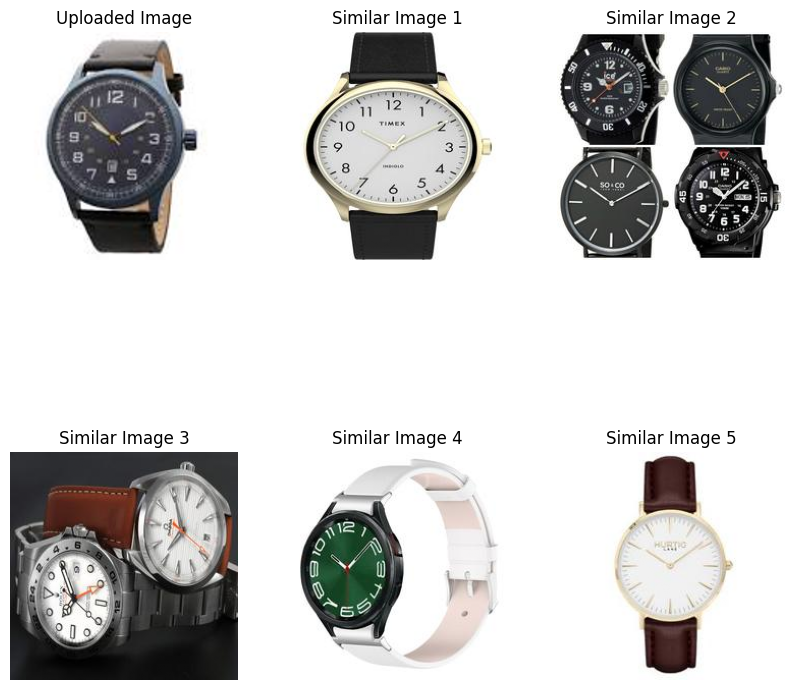

In [10]:
from google.colab import files

# Upload an image from your local machine
uploaded = files.upload()

# Load and preprocess the uploaded image
for fn in uploaded.keys():
    img = Image.open(fn)
    img = preprocess_image(img)
    query_vector = get_feature_embeddings(img.reshape(1, 224, 224, 3))

    # Search for similar images using FAISS
    top_5_indices = search_similar_images_faiss(query_vector)

    # Retrieve the paths of the top 5 similar images
    top_5_image_paths = [image_paths[i] for i in top_5_indices]

    # Display the uploaded image
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 3, 1)  # Adjust grid size for 5 images (2 rows, 3 columns)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')

    # Display the top 5 most similar images
    for i, img_path in enumerate(top_5_image_paths):
        similar_img = Image.open(img_path)
        similar_img = preprocess_image(similar_img)
        plt.subplot(2, 3, i + 2)
        plt.imshow(similar_img)
        plt.title(f"Similar Image {i+1}")
        plt.axis('off')

    plt.show()


In [ ]:
import numpy as np

# Save the feature vectors as a .npy file
np.save('/content/feature_vectors.npy', feature_vectors)

In [ ]:
# Save the FAISS index
faiss.write_index(index, '/content/faiss_index.index')


In [ ]:
import pickle

# Save the image paths using pickle
with open('/content/image_paths.pkl', 'wb') as f:
    pickle.dump(image_paths, f)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the files to your Google Drive
!cp /content/feature_vectors.npy /content/drive/MyDrive/MyModel/
!cp /content/faiss_index.index /content/drive/MyDrive/MyModel/
!cp /content/image_paths.pkl /content/drive/MyDrive/MyModel/

Mounted at /content/drive


In [ ]:
# Save the model in Google Drive
model.save('/content/drive/MyDrive/MyModel/inceptionv3_model.h5')

In [ ]:
!cp /content/ /content/drive/MyDrive/